# Movie Recommendation with Content-Based and Collaborative Filtering

In this notebook, I will attempt at implementing these two systems to recommend movies and evaluate them to see which one performs better.

After reading this post you will know:

* About the MovieLens dataset problem for recommender system.
* How to load and process the data.
* How to do exploratory data analysis.
* The 2 different types of recommendation engines.
* How to develop a content-based recommendation model based on movie genres.
* How to develop a collaborative filtering model based on user ratings.
* Alternative approach to improve existing models.

Let’s get started.

## The MovieLens Dataset
One of the most common datasets that is available on the internet for building a Recommender System is the [MovieLens DataSet](https://grouplens.org/datasets/movielens/). This version of the dataset that I'm working with ([1M](https://grouplens.org/datasets/movielens/1m/)) contains 1,000,209 anonymous ratings of approximately 3,900 movies made by 6,040 MovieLens users who joined MovieLens in 2000.

The data was collected by GroupLens researchers over various periods of time, depending on the size of the set. This 1M version was released on February 2003. Users were selected at random for inclusion. All users selected had rated at least 20 movies. Each user is represented by an id, and no other information is provided.

The original data are contained in three files, [movies.dat](https://github.com/khanhnamle1994/movielens/blob/master/dat/movies.dat), [ratings.dat](https://github.com/khanhnamle1994/movielens/blob/master/dat/ratings.dat) and [users.dat](https://github.com/khanhnamle1994/movielens/blob/master/dat/users.dat). To make it easier to work with the data, I converted them into csv files. The process can be viewed in my [Data Processing Notebook](https://github.com/khanhnamle1994/movielens/blob/master/Data_Processing.ipynb).

![movielens](images/movielens.jpg)

## Data Preparation
Let's load this data into Python. I will load the dataset with Pandas onto Dataframes **ratings**, **users**, and **movies**. Before that, I'll also pass in column names for each CSV and read them using pandas (the column names are available in the [Readme](https://github.com/khanhnamle1994/movielens/blob/master/README.md) file).

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Reading ratings file
# Ignore the timestamp column
process_file = "processed_data/"
ratings_file = process_file + 'ratings.csv'
ratings = pd.read_csv(ratings_file, sep='\t', encoding='latin-1', usecols=['user_id', 'movie_id', 'rating'])

# Reading users file
users_file = process_file + 'users.csv'
users = pd.read_csv(users_file, sep='\t', encoding='latin-1', usecols=['user_id', 'gender', 'zipcode', 'age_desc', 'occ_desc'])



In [189]:
# Reading movies file
movies_file = process_file + 'movies.csv'
movies = pd.read_csv(movies_file, sep='\t', encoding='latin-1', usecols=['movie_id', 'title', 'genres'])

In [191]:
type(movies)

pandas.core.frame.DataFrame

Now lets take a peak into the content of each file to understand them better.

### Ratings Dataset

In [2]:
# Check the top 5 rows
print(ratings.head())

   user_id  movie_id  rating
0        1      1193       5
1        1       661       3
2        1       914       3
3        1      3408       4
4        1      2355       5


In [3]:
# Check the file info
print(ratings.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000209 entries, 0 to 1000208
Data columns (total 3 columns):
user_id     1000209 non-null int64
movie_id    1000209 non-null int64
rating      1000209 non-null int64
dtypes: int64(3)
memory usage: 22.9 MB
None


In [4]:
print(len(ratings))

1000209


This confirms that there are 1M ratings for different user and movie combinations.

### Users Dataset

In [5]:
# Check the top 5 rows
print(users.head())

   user_id gender zipcode  age_desc              occ_desc
0        1      F   48067  Under 18          K-12 student
1        2      M   70072       56+         self-employed
2        3      M   55117     25-34             scientist
3        4      M   02460     45-49  executive/managerial
4        5      M   55455     25-34                writer


In [6]:
# Check the file info
print(users.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6040 entries, 0 to 6039
Data columns (total 5 columns):
user_id     6040 non-null int64
gender      6040 non-null object
zipcode     6040 non-null object
age_desc    6040 non-null object
occ_desc    6040 non-null object
dtypes: int64(1), object(4)
memory usage: 236.0+ KB
None


In [7]:
print(len(users))

6040


This confirms that there are 6040 users and we have 5 features for each (unique user ID, gender, age, occupation and the zip code they are living in).

### Movies Dataset

In [8]:
# Check the top 5 rows
print(movies.head())

   movie_id                               title                        genres
0         1                    Toy Story (1995)   Animation|Children's|Comedy
1         2                      Jumanji (1995)  Adventure|Children's|Fantasy
2         3             Grumpier Old Men (1995)                Comedy|Romance
3         4            Waiting to Exhale (1995)                  Comedy|Drama
4         5  Father of the Bride Part II (1995)                        Comedy


In [9]:
# Check the file info
print(movies.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3883 entries, 0 to 3882
Data columns (total 3 columns):
movie_id    3883 non-null int64
title       3883 non-null object
genres      3883 non-null object
dtypes: int64(1), object(2)
memory usage: 91.1+ KB
None


In [10]:
print(len(movies))

3883


This dataset contains attributes of the 3883 movies. There are 3 columns including the movie ID, their titles, and their genres. Genres are pipe-separated and are selected from 18 genres (Action, Adventure, Animation, Children's, Comedy, Crime, Documentary, Drama, Fantasy, Film-Noir, Horror, Musical, Mystery, Romance, Sci-Fi, Thriller, War, Western).

## Data Exploration
### Titles
Are there certain words that feature more often in Movie Titles? I'll attempt to figure this out using a word-cloud visualization.

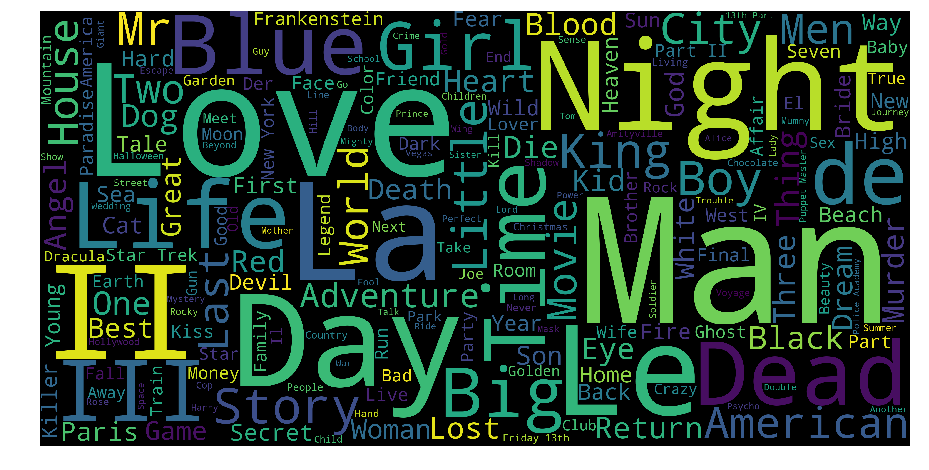

In [11]:
# Import new libraries
%matplotlib inline
import wordcloud
from wordcloud import WordCloud, STOPWORDS

# Create a wordcloud of the movie titles
movies['title'] = movies['title'].fillna("").astype('str')
title_corpus = ' '.join(movies['title'])
title_wordcloud = WordCloud(stopwords=STOPWORDS, background_color='black', height=2000, width=4000).generate(title_corpus)

# Plot the wordcloud
plt.figure(figsize=(16,8))
plt.imshow(title_wordcloud)
plt.axis('off')
plt.show()

Beautiful, isn't it? I can recognize that there are a lot of movie franchises in this dataset, as evidenced by words like *II* and *III*... In addition to that, *Day*, *Love*, *Life*, *Time*, *Night*, *Man*, *Dead*, *American* are among the most commonly occuring words.

### Ratings
Next I want to examine the **rating** further. Let's take a look at its summary statistics and distribution.

In [12]:
# Get summary statistics of rating
ratings['rating'].describe()

count    1.000209e+06
mean     3.581564e+00
std      1.117102e+00
min      1.000000e+00
25%      3.000000e+00
50%      4.000000e+00
75%      4.000000e+00
max      5.000000e+00
Name: rating, dtype: float64

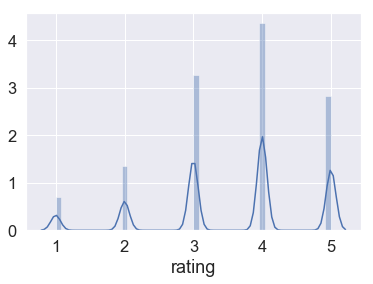

In [14]:
# seaborn与matlotlib同出一源，只是把matplotlib进行了封装，让许多方法调用时变得更加简便
# Import seaborn library
import seaborn as sns
sns.set_style('whitegrid')
sns.set(font_scale=1.5)
%matplotlib inline

# Display distribution of rating
sns.distplot(ratings['rating'].fillna(ratings['rating'].median()))

从上述结果可以看出评分均值大概是3.58。一半以上的用户给出的打分是4或者5分。可能是因为大家不挑剔，或者好好先生的心态。这也可能是用户的打分风格和心态不同，比如A童鞋常常用4分来表示自己心里的平均分，但是B童鞋可能只有真的喜欢的时候才给出4分。每个用户都对20部以上的电影打过分，这样的话，用户的喜好因素可能更大了，所以，本文的数据可能是偶然的了。后续再找其他数据，重新做一次。

我们进一步看看评分最高的20部电影。

In [16]:
# Join all 3 files into one dataframe
dataset = pd.merge(pd.merge(movies, ratings),users)
# 默认是inner内连接
print(dataset.head())

   movie_id                                      title  \
0         1                           Toy Story (1995)   
1        48                          Pocahontas (1995)   
2       150                           Apollo 13 (1995)   
3       260  Star Wars: Episode IV - A New Hope (1977)   
4       527                    Schindler's List (1993)   

                                 genres  user_id  rating gender zipcode  \
0           Animation|Children's|Comedy        1       5      F   48067   
1  Animation|Children's|Musical|Romance        1       5      F   48067   
2                                 Drama        1       5      F   48067   
3       Action|Adventure|Fantasy|Sci-Fi        1       4      F   48067   
4                             Drama|War        1       5      F   48067   

   age_desc      occ_desc  
0  Under 18  K-12 student  
1  Under 18  K-12 student  
2  Under 18  K-12 student  
3  Under 18  K-12 student  
4  Under 18  K-12 student  


In [20]:
print(len(dataset[['title','genres','rating']].sort_values('rating', ascending=False)))

1000209


简单查看：

In [124]:
# Display 20 movies with highest ratings
dataset[['title','genres','rating']].sort_values('rating', ascending=False).head(20)

,title,genres,rating
0,Toy Story (1995),Animation|Children's|Comedy,5
489283,American Beauty (1999),Comedy|Drama,5
489259,Election (1999),Comedy,5
489257,"Matrix, The (1999)",Action|Sci-Fi|Thriller,5
489256,Dead Ringers (1988),Drama|Thriller,5
489237,Rushmore (1998),Comedy,5
489236,"Simple Plan, A (1998)",Crime|Thriller,5
489226,Hands on a Hard Body (1996),Documentary,5
489224,Pleasantville (1998),Comedy,5
489212,Say Anything... (1989),Comedy|Drama|Romance,5


sort_values，根据某一列排序，原来的pd顺序没变，只是返回的是排序的结果。

看下用户评分为5数量最多的电影的Top20

In [19]:
print(len(dataset))#与打分的数量一致
dataset['rating'].value_counts()

1000209


4    348971
3    261197
5    226310
2    107557
1     56174
Name: rating, dtype: int64

In [22]:
# 需要先对评分为5的分组，统计评分人数最多的top20个电影
rate_5 = dataset[dataset['rating']==5]

In [23]:
print(len(rate_5))
# 这个结果与之前的226310是一致的

226310


In [70]:
# 按照电影id进行分组统计
group_movie_id = rate_5.groupby('movie_id').size()
print(group_movie_id.head())

movie_id
1    820
2     48
3     43
4      6
5     16
dtype: int64


In [71]:
# 从原始数据来看，进行进一步验证
print(len(ratings[(ratings['rating']==5) & (ratings['movie_id']==1)]))
print(len(ratings[(ratings['rating']==5) & (ratings['movie_id']==5)]))

820
16


In [ ]:
从上述两个结果可以看出，结果也是一致的。

In [83]:
print(type(group_movie_id))
print(len(group_movie_id))
#print(group_movie_id.sort_index())
print(group_movie_id.name)
print(group_movie_id.index)
print(group_movie_id.index.name)
print(group_movie_id.values)
print(type(group_movie_id.values))
#temp_dict = dict(list(group_movie_id))

<class 'pandas.core.series.Series'>
3232
None
Int64Index([2044, 3881, 3522, 1501, 1502, 3883, 1519,  336, 1525,  331,
            ...
            2762, 2028, 2571,  318,  527,  858, 1196, 1198,  260, 2858],
           dtype='int64', name='movie_id', length=3232)
movie_id
[   1    1    1 ..., 1500 1826 1963]
<class 'numpy.ndarray'>


In [88]:
print(group_movie_id.sort_values(ascending=False).head())
# 为啥不是按照value值排序？？

movie_id
2858    1963
260     1826
1198    1500
1196    1483
858     1475
dtype: int64


In [91]:
print(group_movie_id.sort_values(ascending=False).tail(20))

movie_id
130     1
3268    1
2350    1
3940    1
2914    1
2892    1
2884    1
2545    1
114     1
2552    1
2911    1
3216    1
2923    1
2368    1
2555    1
2358    1
3303    1
2557    1
2386    1
2044    1
dtype: int64


In [93]:
# 进一步校验，movid=2858,评分为5出现的次数数1963
print(len(ratings[(ratings['rating']==5) & (ratings['movie_id']==2858)]))
print(len(ratings[(ratings['rating']==5) & (ratings['movie_id']==2386)]))

1963
1


可以看出，结果与预期也是一致的。

In [94]:
# 显示top20的电影信息
top_20_rate_5 = group_movie_id.sort_values(ascending=False).head(20)
print(type(top_20_rate_5))

<class 'pandas.core.series.Series'>


In [96]:
moveid_set = set(top_20_rate_5.index)

In [101]:
print(moveid_set)

{608, 260, 296, 1210, 2858, 2571, 1196, 2028, 1198, 527, 2762, 593, 110, 1197, 50, 1617, 2997, 858, 2396, 318}


In [125]:
print(dataset['movie_id'].isin(moveid_set).head(20))

0     False
1     False
2     False
3      True
4      True
5     False
6     False
7     False
8     False
9      True
10    False
11    False
12    False
13    False
14    False
15    False
16    False
17    False
18    False
19    False
Name: movie_id, dtype: bool


In [104]:
print(len(dataset[dataset['movie_id'].isin(moveid_set)]))

49966


In [126]:
dataset[dataset['movie_id'].isin(moveid_set)].head()

,movie_id,title,genres,user_id,rating,gender,zipcode,age_desc,occ_desc
3,260,Star Wars: Episode IV - A New Hope (1977),Action|Adventure|Fantasy|Sci-Fi,1,4,F,48067,Under 18,K-12 student
4,527,Schindler's List (1993),Drama|War,1,5,F,48067,Under 18,K-12 student
9,608,Fargo (1996),Crime|Drama|Thriller,1,4,F,48067,Under 18,K-12 student
23,1197,"Princess Bride, The (1987)",Action|Adventure|Comedy|Romance,1,3,F,48067,Under 18,K-12 student
36,2028,Saving Private Ryan (1998),Action|Drama|War,1,5,F,48067,Under 18,K-12 student


In [127]:
temp_pd = dataset[dataset['movie_id'].isin(moveid_set) & (dataset['rating']==5)]
temp_pd[['title','genres','rating']].head(20)

,title,genres,rating
4,Schindler's List (1993),Drama|War,5
36,Saving Private Ryan (1998),Action|Drama|War,5
137,Braveheart (1995),Action|Drama|War,5
150,Pulp Fiction (1994),Crime|Drama,5
169,Fargo (1996),Crime|Drama|Thriller,5
212,Saving Private Ryan (1998),Action|Drama|War,5
222,Shakespeare in Love (1998),Comedy|Romance,5
228,"Matrix, The (1999)",Action|Sci-Fi|Thriller,5
236,American Beauty (1999),Comedy|Drama,5
272,"Shawshank Redemption, The (1994)",Drama,5


### Genres(流派/类型)
电影的类型信息比如动作，爱情等都是可以简单对电影内容的相似度聚合。为此，我们可以尝试看看最流行的电影类型。

In [128]:
# Make a census of the genre keywords
genre_labels = set()
for s in movies['genres'].str.split('|').values:
    genre_labels = genre_labels.union(set(s))

# Function that counts the number of times each of the genre keywords appear
def count_word(dataset, ref_col, census):
    keyword_count = dict()
    for s in census: 
        keyword_count[s] = 0
    for census_keywords in dataset[ref_col].str.split('|'):        
        if type(census_keywords) == float and pd.isnull(census_keywords): 
            continue        
        for s in [s for s in census_keywords if s in census]: 
            if pd.notnull(s): 
                keyword_count[s] += 1
    #______________________________________________________________________
    # convert the dictionary in a list to sort the keywords by frequency
    keyword_occurences = []
    for k,v in keyword_count.items():
        keyword_occurences.append([k,v])
    keyword_occurences.sort(key = lambda x:x[1], reverse = True)
    return keyword_occurences, keyword_count

# Calling this function gives access to a list of genre keywords which are sorted by decreasing frequency
keyword_occurences, dum = count_word(movies, 'genres', genre_labels)
keyword_occurences[:5]

[['Drama', 1603],
 ['Comedy', 1200],
 ['Action', 503],
 ['Thriller', 492],
 ['Romance', 471]]

可以看出最流行的5种电影是: Drama, Comedy, Action, Thriller, and Romance。

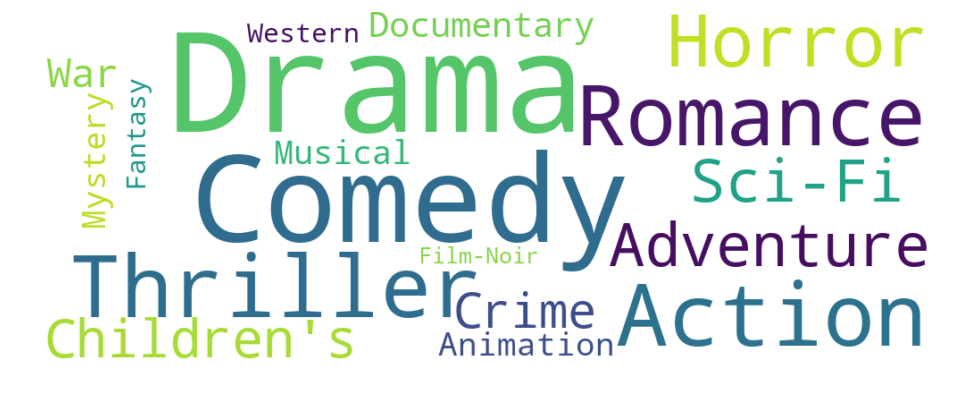

In [17]:
# Define the dictionary used to produce the genre wordcloud
genres = dict()
trunc_occurences = keyword_occurences[0:18]
for s in trunc_occurences:
    genres[s[0]] = s[1]

# Create the wordcloud
genre_wordcloud = WordCloud(width=1000,height=400, background_color='white')
genre_wordcloud.generate_from_frequencies(genres)

# Plot the wordcloud
f, ax = plt.subplots(figsize=(16, 8))
plt.imshow(genre_wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

## 推荐系统

### 1. Content-Based
The Content-Based Recommender relies on the similarity of the items being recommended. The basic idea is that if you like an item, then you will also like a “similar” item. It generally works well when it's easy to determine the context/properties of each item.

A content based recommender works with data that the user provides, either explicitly movie ratings for the MovieLens dataset. Based on that data, a user profile is generated, which is then used to make suggestions to the user. As the user provides more inputs or takes actions on the recommendations, the engine becomes more and more accurate.

### 2. Collaborative Filtering
The Collaborative Filtering Recommender is entirely based on the past behavior and not on the context. More specifically, it is based on the similarity in preferences, tastes and choices of two users. It analyses how similar the tastes of one user is to another and makes recommendations on the basis of that. 

For instance, if user A likes movies 1, 2, 3 and user B likes movies 2,3,4, then they have similar interests and A should like movie 4 and B should like movie 1. This makes it one of the most commonly used algorithm as it is not dependent on any additional information.

In general, collaborative filtering is the workhorse of recommender engines. The algorithm has a very interesting property of being able to do feature learning on its own, which means that it can start to learn for itself what features to use. It can be divided into **Memory-Based Collaborative Filtering** and **Model-Based Collaborative filtering**. In this post, I'll only focus on the Memory-Based Collaborative Filtering technique.

![rec-systems](images/rec-systems.png)

## Content-Based Recommendation Model
### Theory
The concepts of **Term Frequency (TF)** and **Inverse Document Frequency (IDF)** are used in information retrieval systems and also content based filtering mechanisms (such as a content based recommender). They are used to determine the relative importance of a document / article / news item / movie etc.

TF is simply the frequency of a word in a document. IDF is the inverse of the document frequency among the whole corpus of documents. TF-IDF is used mainly because of two reasons: Suppose we search for “**the results of latest European Socccer games**” on Google. It is certain that “**the**” will occur more frequently than “**soccer games**” but the relative importance of **soccer games** is higher than the search query point of view. In such cases, TF-IDF weighting negates the effect of high frequency words in determining the importance of an item (document).

Below is the equation to calculate the TF-IDF score:
![tfidf](images/tfidf.jpg)

After calculating TF-IDF scores, how do we determine which items are closer to each other, rather closer to the user profile? This is accomplished using the **Vector Space Model** which computes the proximity based on the angle between the vectors. In this model, each item is stored as a vector of its attributes (which are also vectors) in an **n-dimensional space** and the angles between the vectors are calculated to **determine the similarity between the vectors**. Next, the user profile vectors are also created based on his actions on previous attributes of items and the similarity between an item and a user is also determined in a similar way.

![vector-space](images/vector_space.png)

Sentence 2 is more likely to be using Term 2 than using Term 1. Vice-versa for Sentence 1. The method of calculating this relative measure is calculated by taking the cosine of the angle between the sentences and the terms. The ultimate reason behind using cosine is that the **value of cosine will increase with decreasing value of the angle** between which signifies more similarity. The vectors are length normalized after which they become vectors of length 1 and then the cosine calculation is simply the sum-product of vectors.

### Implementation

接下来，我们将基于movie的类型信息进行推荐。所以，这里我们简单采用电影的genres这个信息作为特征。

In [129]:
# Break up the big genre string into a string array
movies['genres'] = movies['genres'].str.split('|')
# Convert genres to string value
movies['genres'] = movies['genres'].fillna("").astype('str')

In [154]:
print(len(movies))

3883


In [155]:
movies.head()

,movie_id,title,genres
0,1,Toy Story (1995),"['Animation', ""Children's"", 'Comedy']"
1,2,Jumanji (1995),"['Adventure', ""Children's"", 'Fantasy']"
2,3,Grumpier Old Men (1995),"['Comedy', 'Romance']"
3,4,Waiting to Exhale (1995),"['Comedy', 'Drama']"
4,5,Father of the Bride Part II (1995),['Comedy']


我们暂时没有定量的评估方法，所以只能从定性的角度来分析。我们这里定性的分析是基于**scikit-learn**的**TfidfVectorizer**。该函数能将文本转为特征向量，再进行评估。

In [130]:
from sklearn.feature_extraction.text import TfidfVectorizer
tf = TfidfVectorizer(analyzer='word',ngram_range=(1, 2),min_df=0, stop_words='english')
tfidf_matrix = tf.fit_transform(movies['genres'])
tfidf_matrix.shape

(3883, 127)

这里我们采用余弦相似度来衡量两部电影之间的相似性。由于我们已经计算出了TF-IDF Vectorizer，所以可以直接计算各个向量直接的余弦相似度。本文这里采用的sklearn的 **linear_kernel** 方法来求余弦相似度(因为更快)。

In [131]:
from sklearn.metrics.pairwise import linear_kernel
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)
cosine_sim[:4, :4]

array([[ 1.        ,  0.14193614,  0.09010857,  0.1056164 ],
       [ 0.14193614,  1.        ,  0.        ,  0.        ],
       [ 0.09010857,  0.        ,  1.        ,  0.1719888 ],
       [ 0.1056164 ,  0.        ,  0.1719888 ,  1.        ]])

In [156]:
print(cosine_sim.shape)

(3883, 3883)


In [163]:
sim_scores = list(enumerate(cosine_sim[2]))
print(len(sim_scores))
print(sim_scores[:5])
print(cosine_sim[2][:5])

3883
[(0, 0.090108572739686227), (1, 0.0), (2, 0.99999999999999978), (3, 0.17198879618645613), (4, 0.38306057669114663)]
[ 0.09010857  0.          1.          0.1719888   0.38306058]


至此，我们计算得出所有电影之间的相似性,接下来就是根据输入返回相似性top20的电影。

In [132]:
# Build a 1-dimensional array with movie titles
titles = movies['title']
indices = pd.Series(movies.index, index=movies['title'])

# Function that get movie recommendations based on the cosine similarity score of movie genres
def genre_recommendations(title):
    idx = indices[title]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:21]
    movie_indices = [i[0] for i in sim_scores]
    return titles.iloc[movie_indices]
#enumerate用于将一个可遍历的数据对象(如列表、元组或字符串)组合为一个索引序列，同时列出数据和数据下标

In [157]:
indices.head()

title
Toy Story (1995)                      0
Jumanji (1995)                        1
Grumpier Old Men (1995)               2
Waiting to Exhale (1995)              3
Father of the Bride Part II (1995)    4
dtype: int64

运行结果如下：

In [165]:
genre_recommendations('Good Will Hunting (1997)').head(20)

25                                        Othello (1995)
26                                   Now and Then (1995)
29     Shanghai Triad (Yao a yao yao dao waipo qiao) ...
30                                Dangerous Minds (1995)
35                               Dead Man Walking (1995)
39                       Cry, the Beloved Country (1995)
42                                    Restoration (1995)
52                                       Lamerica (1994)
54                                        Georgia (1995)
56                          Home for the Holidays (1995)
61                             Mr. Holland's Opus (1995)
66                                       Two Bits (1995)
77                            Crossing Guard, The (1995)
79          White Balloon, The (Badkonake Sefid ) (1995)
81                       Antonia's Line (Antonia) (1995)
82       Once Upon a Time... When We Were Colored (1995)
89                    Journey of August King, The (1995)
92                             

In [134]:
genre_recommendations('Toy Story (1995)').head(20)

1050               Aladdin and the King of Thieves (1996)
2072                             American Tail, An (1986)
2073           American Tail: Fievel Goes West, An (1991)
2285                            Rugrats Movie, The (1998)
2286                                 Bug's Life, A (1998)
3045                                   Toy Story 2 (1999)
3542                                Saludos Amigos (1943)
3682                                   Chicken Run (2000)
3685       Adventures of Rocky and Bullwinkle, The (2000)
236                                 Goofy Movie, A (1995)
12                                           Balto (1995)
241                               Gumby: The Movie (1995)
310                             Swan Princess, The (1994)
592                                      Pinocchio (1940)
612                                Aristocats, The (1970)
700                               Oliver & Company (1988)
876     Land Before Time III: The Time of the Great Gi...
1010          

In [135]:
genre_recommendations('Saving Private Ryan (1998)').head(20)

461            Heaven & Earth (1993)
1204        Full Metal Jacket (1987)
1214     Boat, The (Das Boot) (1981)
1222                    Glory (1989)
1545                G.I. Jane (1997)
1959      Saving Private Ryan (1998)
2358       Thin Red Line, The (1998)
2993         Longest Day, The (1962)
3559            Flying Tigers (1942)
3574    Fighting Seabees, The (1944)
3585    Guns of Navarone, The (1961)
3684             Patriot, The (2000)
40                Richard III (1995)
153            Beyond Rangoon (1995)
332         Walking Dead, The (1995)
523          Schindler's List (1993)
641        Courage Under Fire (1996)
967          Nothing Personal (1995)
979           Michael Collins (1996)
1074                  Platoon (1986)
Name: title, dtype: object

从上述可以可以看出对于**Good Will Hunting** (Drama), **Toy Story** (Animation, Children's, Comedy), and **Saving Private Ryan** (Action, Thriller, War)这三种电影类型的一个推荐，效果还是不错的。

## 基于协同过滤的推荐系统
该方法的核心思想其实跟Word2Vec很像，用物以类聚的方式来推荐。相似的人，可能喜欢相近，所以可能会有惊喜的推荐。基于人的相似和物的相似有两种协同过滤，分别是**User-User Collaborative Filtering**和**Item-Item Collaborative Filtering**。
![user_item_cf](images/user_item_cf.jpg)

There are 3 distance similarity metrics that are usually used in collaborative filtering:
1. **Jaccard Similarity**:
    * Similarity is based on the number of users which have rated item A and B divided by the number of users who have rated either A or B
    * It is typically used where we don’t have a numeric rating but just a boolean value like a product being bought or an add being clicked

2. **Cosine Similarity**: (as in the Content-Based system)
    * Similarity is the cosine of the angle between the 2 vectors of the item vectors of A and B
    * Closer the vectors, smaller will be the angle and larger the cosine

3. **Pearson Similarity**:
    * Similarity is the pearson coefficient between the two vectors.

之前用过余弦相似度，，我们这里尝试用 **Pearson Similarity** 

### 基于用户的协同过滤
I will use the file **ratings.csv** first as it contains User ID, Movie IDs and Ratings. These three elements are all I need for determining the similarity of the users based on their ratings for a particular movie.

First I do some quick data processing:

In [12]:
# Fill NaN values in user_id and movie_id column with 0，空值赋0
ratings['user_id'] = ratings['user_id'].fillna(0)
ratings['movie_id'] = ratings['movie_id'].fillna(0)

# Replace NaN values in rating column with average of all values，未打分的取均值
ratings['rating'] = ratings['rating'].fillna(ratings['rating'].mean())

当计算资源有限时候可以采样，本文采样0.03数据集进行处理。否则，相似度矩阵过大，内存不足以支撑。

In [13]:
# Randomly sample 1% of the ratings dataset
small_data = ratings.sample(frac=0.03)#采样比例可以再调节
# Check the sample info
print(small_data.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30006 entries, 262272 to 979138
Data columns (total 3 columns):
user_id     30006 non-null int64
movie_id    30006 non-null int64
rating      30006 non-null int64
dtypes: int64(3)
memory usage: 937.7 KB
None


Now I use the **scikit-learn library** to split the dataset into testing and training.  **Cross_validation.train_test_split** shuffles and splits the data into two datasets according to the percentage of test examples, which in this case is 0.2.

In [14]:
from sklearn import cross_validation as cv
train_data, test_data = cv.train_test_split(small_data, test_size=0.2)

d:\python35\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


Now I need to create a user-item matrix. Since I have splitted the data into testing and training, I need to create two matrices. The training matrix contains 80% of the ratings and the testing matrix contains 20% of the ratings.

In [15]:
# Create two user-item matrices, one for training and another for testing
train_data_matrix = train_data.as_matrix(columns = ['user_id', 'movie_id', 'rating'])
test_data_matrix = test_data.as_matrix(columns = ['user_id', 'movie_id', 'rating'])

# Check their shape
print(train_data_matrix.shape)
print(test_data_matrix.shape)

(24004, 3)
(6002, 3)


In [16]:
train_data_matrix[:10,:]

array([[1415,  296,    4],
       [ 235, 1997,    3],
       [5105, 2762,    2],
       [3411,  112,    3],
       [ 975, 2908,    4],
       [5096, 2144,    4],
       [4090, 2565,    4],
       [3726,  329,    3],
       [1207, 1503,    1],
       [2544, 2096,    3]], dtype=int64)

In [64]:
ratings.head()

,user_id,movie_id,rating
0,1,1193,5
1,1,661,3
2,1,914,3
3,1,3408,4
4,1,2355,5


这里我们采样皮尔逊相关系数[Pearson Correlation Coefficient](https://stackoverflow.com/questions/1838806/euclidean-distance-vs-pearson-correlation-vs-cosine-similarity)来度量向量之间的相似性。

In [65]:
# 获取数据
def readFile(filename):
    files = open(filename, "r", encoding="utf-8")
    # 如果读取不成功试一下
    # files = open(filename, "r", encoding="iso-8859-15")
    data = []
    for line in files.readlines():
        item = line.strip().split("::")
        data.append(item)
    return data

raw_ratings = readFile("raw_data/ratings.dat") #重新从原始数据读取，结果有3706部被用户评论电影，6040位用户参与电影评论

In [67]:
raw_ratings[:3]

[['1', '1193', '5', '978300760'],
 ['1', '661', '3', '978302109'],
 ['1', '914', '3', '978301968']]

In [91]:
%%time
# 上述的数据形式没有按照预期的方式展示，所以我们需要做进一步的转换
# 将ratings转换为userDict和ItemUser
# userDict矩阵的尺寸为user_num X item_num,Value(i,j)是用户i对item j的评分结果
temp_ratings = raw_ratings # 
print("处理的数据为%d条" % (len(temp_ratings)))

userDict = {} #表示某个用户的所有电影的评分集合，并对评分除以5进行归一化
ItemUser = {} #表示某部电影参与评分的所有用户集合
for i in temp_ratings:
    # 评分最高为5 除以5 进行数据归一化
    temp = (i[1], float(i[2]) / 5)
    # 计算userDict {'1':[(1,5),(2,5)...],'2':[...]...}
    # 每个用户对于电影的评分
    if(i[0] in userDict):
        userDict[i[0]].append(temp)
    else:
        userDict[i[0]] = [temp]
    # 计算ItemUser {'1',[1,2,3..],...}
    if(i[1] in ItemUser):
        ItemUser[i[1]].append(i[0])
    else:
        ItemUser[i[1]] = [i[0]]


处理的数据为1000209条
Wall time: 1.43 s


In [75]:
print(type(ItemUser))
print(len(ItemUser))
print(len(ItemUser["2"]))
print(len(userDict))
print(userDict["1"])

<class 'dict'>
3706
701
6040
[('1193', 1.0), ('661', 0.6), ('914', 0.6), ('3408', 0.8), ('2355', 1.0), ('1197', 0.6), ('1287', 1.0), ('2804', 1.0), ('594', 0.8), ('919', 0.8), ('595', 1.0), ('938', 0.8), ('2398', 0.8), ('2918', 0.8), ('1035', 1.0), ('2791', 0.8), ('2687', 0.6), ('2018', 0.8), ('3105', 1.0), ('2797', 0.8), ('2321', 0.6), ('720', 0.6), ('1270', 1.0), ('527', 1.0), ('2340', 0.6), ('48', 1.0), ('1097', 0.8), ('1721', 0.8), ('1545', 0.8), ('745', 0.6), ('2294', 0.8), ('3186', 0.8), ('1566', 0.8), ('588', 0.8), ('1907', 0.8), ('783', 0.8), ('1836', 1.0), ('1022', 1.0), ('2762', 0.8), ('150', 1.0), ('1', 1.0), ('1961', 1.0), ('1962', 0.8), ('2692', 0.8), ('260', 0.8), ('1028', 1.0), ('1029', 1.0), ('1207', 0.8), ('2028', 1.0), ('531', 0.8), ('3114', 0.8), ('608', 0.8), ('1246', 0.8)]


In [74]:
ratings.head()

,user_id,movie_id,rating
0,1,1193,5
1,1,661,3
2,1,914,3
3,1,3408,4
4,1,2355,5


从ratings转换到ItemUser和userDict

In [90]:
%%time
temp_ratings = ratings
userDict_rating = {} #表示某个用户的所有电影的评分集合，并对评分除以5进行归一化
ItemUser_rating = {} #表示某部电影参与评分的所有用户集合
for (index, row) in temp_ratings.iterrows():
    #print(row)
    #print(row)
    # 评分最高为5 除以5 进行数据归一化
    temp = (row[1], float(row[2]) / 5)
    # 计算userDict {'1':[(1,5),(2,5)...],'2':[...]...}
    # 每个用户对于电影的评分
    if(row[0] in userDict_rating):
        userDict_rating[row[0]].append(temp)
    else:
        userDict_rating[row[0]] = [temp]
    # 计算ItemUser {'1',[1,2,3..],...}
    if(row[1] in ItemUser_rating):
        ItemUser_rating[row[1]].append(row[0])
    else:
        ItemUser_rating[row[1]] = [row[0]]


Wall time: 1min 57s


In [95]:
print(len(ItemUser_rating[2]))
print(userDict_rating[1])

701
[(1193, 1.0), (661, 0.6), (914, 0.6), (3408, 0.8), (2355, 1.0), (1197, 0.6), (1287, 1.0), (2804, 1.0), (594, 0.8), (919, 0.8), (595, 1.0), (938, 0.8), (2398, 0.8), (2918, 0.8), (1035, 1.0), (2791, 0.8), (2687, 0.6), (2018, 0.8), (3105, 1.0), (2797, 0.8), (2321, 0.6), (720, 0.6), (1270, 1.0), (527, 1.0), (2340, 0.6), (48, 1.0), (1097, 0.8), (1721, 0.8), (1545, 0.8), (745, 0.6), (2294, 0.8), (3186, 0.8), (1566, 0.8), (588, 0.8), (1907, 0.8), (783, 0.8), (1836, 1.0), (1022, 1.0), (2762, 0.8), (150, 1.0), (1, 1.0), (1961, 1.0), (1962, 0.8), (2692, 0.8), (260, 0.8), (1028, 1.0), (1029, 1.0), (1207, 0.8), (2028, 1.0), (531, 0.8), (3114, 0.8), (608, 0.8), (1246, 0.8)]


In [ ]:
上述的遍历速度，比此前的list方案要慢很多。采用下面的遍历方式快很多。

In [103]:
%%time
temp_ratings = ratings
userDict_rating = {} #表示某个用户的所有电影的评分集合，并对评分除以5进行归一化
ItemUser_rating = {} #表示某部电影参与评分的所有用户集合
for row in temp_ratings.itertuples():
    # 评分最高为5 除以5 进行数据归一化
    #print(row[0])
    # user_id', 'movie_id', 'rating
    #getattr(row, "user_id")
    temp = (row[2], float(row[3]) / 5)
    # 计算userDict {'1':[(1,5),(2,5)...],'2':[...]...}
    # 每个用户对于电影的评分
    if(row[1] in userDict_rating):
        userDict_rating[row[1]].append(temp)
    else:
        userDict_rating[row[1]] = [temp]
    # 计算ItemUser {'1',[1,2,3..],...}
    if(row[2] in ItemUser_rating):
        ItemUser_rating[row[2]].append(row[1])
    else:
        ItemUser_rating[row[2]] = [row[1]]

Wall time: 1.7 s


In [104]:
print(len(ItemUser_rating[2]))
print(userDict_rating[1])

701
[(1193, 1.0), (661, 0.6), (914, 0.6), (3408, 0.8), (2355, 1.0), (1197, 0.6), (1287, 1.0), (2804, 1.0), (594, 0.8), (919, 0.8), (595, 1.0), (938, 0.8), (2398, 0.8), (2918, 0.8), (1035, 1.0), (2791, 0.8), (2687, 0.6), (2018, 0.8), (3105, 1.0), (2797, 0.8), (2321, 0.6), (720, 0.6), (1270, 1.0), (527, 1.0), (2340, 0.6), (48, 1.0), (1097, 0.8), (1721, 0.8), (1545, 0.8), (745, 0.6), (2294, 0.8), (3186, 0.8), (1566, 0.8), (588, 0.8), (1907, 0.8), (783, 0.8), (1836, 1.0), (1022, 1.0), (2762, 0.8), (150, 1.0), (1, 1.0), (1961, 1.0), (1962, 0.8), (2692, 0.8), (260, 0.8), (1028, 1.0), (1029, 1.0), (1207, 0.8), (2028, 1.0), (531, 0.8), (3114, 0.8), (608, 0.8), (1246, 0.8)]


In [116]:
print(train_data.shape)
print(train_data[:3])
print(type(train_data))

(24004, 3)
        user_id  movie_id  rating
232788     1415       296       4
34825       235      1997       3
850155     5105      2762       2
<class 'pandas.core.frame.DataFrame'>


构建user-item矩阵，行方向是userid，列方向是movieid。
该矩阵的（i，j）表示user i对电影j的评价。行和列方向，都以单独一个list存储具体的userid和movieid。

In [137]:
from collections import defaultdict
import collections
# 尝试2
n_users = ratings.user_id.unique().shape[0]
n_items = ratings.movie_id.unique().shape[0]
print('Number of users = ' + str(n_users) + ' | Number of movies = ' + str(n_items))

train_data_matrix_new = np.zeros((n_users, n_items))

movie2users = collections.defaultdict(set)
movie_popular = defaultdict(int)
user_list = []
item_list = []

for index, row in train_data.iterrows():
    
    # user_list
    print(row[0],row[1],row[2])
    break
#     for movie in movies:
#         movie2users[movie].add(user)#每个movie下用户的评论情况
#         movie_popular[movie] += 1
print('building movie-users inverse table success.')



Number of users = 6040 | Number of movies = 3706
1415 296 4
building movie-users inverse table success.


In [133]:
#user_id  movie_id  rating
user_movies_df = ratings.pivot(index='user_id', columns='movie_id', values = "rating" ).reset_index(drop=True)
user_movies_df.fillna( 0, inplace = True )

In [134]:
user_movies_df.shape

(6040, 3706)

In [135]:
user_movies_df.head()

movie_id,1,2,3,4,5,6,7,8,9,10,...,3943,3944,3945,3946,3947,3948,3949,3950,3951,3952
0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [175]:
user_movies_df.iloc[:10, 10:20]

movie_id,11,12,13,14,15,16,17,18,19,20
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,4.0,0.0,4.0,4.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [157]:
# userid=6040的电影点评信息
user_movies_df.iloc[[6039]]# 第6040行数据
# 筛选出非0的，以进一步和原始数据对比


movie_id,1,2,3,4,5,6,7,8,9,10,...,3943,3944,3945,3946,3947,3948,3949,3950,3951,3952
6039,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [170]:
#user_movies_df.loc[[6039]]
print(user_movies_df.columns)
print(user_movies_df.index)

Int64Index([   1,    2,    3,    4,    5,    6,    7,    8,    9,   10,
            ...
            3943, 3944, 3945, 3946, 3947, 3948, 3949, 3950, 3951, 3952],
           dtype='int64', name='movie_id', length=3706)
RangeIndex(start=0, stop=6040, step=1)


In [164]:
user_movies_df.ix[[6039]]# 第6040行数据

movie_id,1,2,3,4,5,6,7,8,9,10,...,3943,3944,3945,3946,3947,3948,3949,3950,3951,3952
6039,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [140]:
print(user_movies_df.index)
#???但是原始的index是表示用户id，是从1开始啊？？？？？？？？？
# ？？？？？？？？？

RangeIndex(start=0, stop=6040, step=1)


In [172]:
type(user_movies_df)

pandas.core.frame.DataFrame

In [ ]:
# train_data 数据尺寸 (24004, 3)
# test_data 数据尺寸 (6002, 3)
# 这里列方向对应的movie_id用一个list记录
# 行方向的userid也用一个list记录，然后两者构建两个字典

# 预先规定好，行方向和列方向上，各个位置上表示的id。
for line in train_data.itertuples():
    #print(line[0],line[1],line[2],line[3])
    train_data_matrix_new[line[1]-1, line[2]-1] = line[3]
    # i，j位置存储i用户对j电影的评分。但是这样会在用户id值大的时候越界的
test_data_matrix_new = np.zeros((n_users, n_items))
for line in test_data.itertuples():
    test_data_matrix_new[line[1]-1, line[2]-1] = line[3]

下面的这种求解方式，网络上很多，但是我觉得是错误的。
该矩阵并不是真正表示打分情况，需要先做一步转换才行。
如下文章中的数据形式才可以。
http://www.awesomestats.in/python-recommending-movies/

In [17]:
# 网络上流传的版本，我觉得是错的。放在这里一起看，欢迎大家评论。
from sklearn.metrics.pairwise import pairwise_distances

# pairwise_distances + cosine similarity 等于 1.0
# User Similarity Matrix
user_correlation = 1 - pairwise_distances(train_data, metric='correlation')
user_correlation[np.isnan(user_correlation)] = 0 # 缺失的位置补0
print(user_correlation[:4, :4])

[[ 1.         -0.21795171  0.93107823  0.98572609]
 [-0.21795171  1.          0.15311908 -0.37915028]
 [ 0.93107823  0.15311908  1.          0.85636818]
 [ 0.98572609 -0.37915028  0.85636818  1.        ]]


In [141]:
# 按照我的思路，重新计算的结果。
user_correlation = 1 - pairwise_distances(user_movies_df, metric='correlation')
user_correlation[np.isnan(user_correlation)] = 0 # 缺失的位置补0
print(user_correlation[:4, :4])

[[ 1.          0.07689583  0.10863359  0.12504067]
 [ 0.07689583  1.          0.1340226   0.16108024]
 [ 0.10863359  0.1340226   1.          0.14423706]
 [ 0.12504067  0.16108024  0.14423706  1.        ]]


In [142]:
print(user_correlation.shape)

(6040, 6040)


In [176]:
user_sim_df = pd.DataFrame( user_correlation )
user_sim_df.idxmax(axis=1)[0:5]

0    0
1    1
2    2
3    3
4    4
dtype: int64

上述结果是直接展示对角线的结果，这不是我们想要的。我们先对对角线位置填充0，再重新计算。


In [177]:
np.fill_diagonal( user_correlation, 0 )
user_sim_df = pd.DataFrame( user_correlation )
user_sim_df.idxmax(axis=1).sample( 10, random_state = 10 )

5720    5776
6011    5966
290     3750
1985    1255
1065    2744
413      436
3600     498
4635    4845
1969    1904
5698    4883
dtype: int64

注意，这里的真实的user id是=index number + 1。这意味着用户id=5721和用户id=5777是很相似的。

In [192]:
type(movies)

pandas.core.frame.DataFrame

In [193]:
# 从原始的数据中具体对比我们所谓的相似用户user1和user2的
def get_user_similar_movies( user1, user2 ):
    common_movies = ratings[ratings.user_id == user1].merge( \
      ratings[ratings.user_id == user2],on = "movie_id",how = "inner" )

    return common_movies.merge( movies, on = 'movie_id' )

In [195]:
get_user_similar_movies( 5721, 5777 )

,user_id_x,movie_id,rating_x,user_id_y,rating_y,title,genres
0,5721,1,5,5777,3,Toy Story (1995),Animation|Children's|Comedy
1,5721,3006,3,5777,4,"Insider, The (1999)",Drama
2,5721,593,5,5777,5,"Silence of the Lambs, The (1991)",Drama|Thriller
3,5721,903,4,5777,4,Vertigo (1958),Mystery|Thriller
4,5721,904,5,5777,4,Rear Window (1954),Mystery|Thriller
5,5721,908,5,5777,5,North by Northwest (1959),Drama|Thriller
6,5721,919,5,5777,5,"Wizard of Oz, The (1939)",Adventure|Children's|Drama|Musical
7,5721,1104,4,5777,5,"Streetcar Named Desire, A (1951)",Drama
8,5721,2858,3,5777,5,American Beauty (1999),Comedy|Drama
9,5721,608,4,5777,5,Fargo (1996),Crime|Drama|Thriller


In [23]:
# Item Similarity Matrix
# 计算Item 的相似矩阵，这个版本是与上述错误版本配套的，所以就一起放这里，一起评鉴
item_correlation = 1 - pairwise_distances(train_data_matrix.T, metric='correlation')
item_correlation[np.isnan(item_correlation)] = 0
print(item_correlation[:4, :4])

[[  1.00000000e+00   2.06941018e-04   1.94366017e-02]
 [  2.06941018e-04   1.00000000e+00  -6.31548584e-02]
 [  1.94366017e-02  -6.31548584e-02   1.00000000e+00]]


In [24]:
print(item_correlation.shape)
# ['user_id', 'movie_id', 'rating']只有这3种

(3, 3)


其实，看到这里item的尺寸才3，这就可以立刻反应，这肯定是错了。
所以，按照我们的思路，重新计算一次。

In [143]:
%%time
item_correlation = 1 - pairwise_distances(user_movies_df.T, metric='correlation')
item_correlation[np.isnan(item_correlation)] = 0
print(item_correlation[:4, :4])

[[ 1.          0.26264945  0.14653623  0.10937542]
 [ 0.26264945  1.          0.16958627  0.111616  ]
 [ 0.14653623  0.16958627  1.          0.1586589 ]
 [ 0.10937542  0.111616    0.1586589   1.        ]]


In [144]:
item_correlation.shape

(3706, 3706)

In [ ]:
前面介绍的两种协同过滤都是基于内存，当人数或者电影数很大时候内存很容易耗尽。

在获取了相似矩阵后，可以在test数据集上预测以对推荐系统评估。

基于user的CF，我们

With the similarity matrix in hand, I can now predict the ratings that were not included with the data. Using these predictions, I can then compare them with the test data to attempt to validate the quality of our recommender model.

For the user-user CF case, I will look at the similarity between 2 users (A and B, for example) as weights that are multiplied by the ratings of a similar user B (corrected for the average rating of that user). I also need to normalize it so that the ratings stay between 1 and 5 and, as a final step, sum the average ratings for the user that I am trying to predict. The idea here is that some users may tend always to give high or low ratings to all movies. The relative difference in the ratings that these users give is more important than the absolute values. 

In [199]:
# 需要获取每个用户的平均打分习惯
temp_v = ratings.mean(axis=1) # 按行计算的均值
print(temp_v.shape)

# 

(1000209,)


In [142]:
# Function to predict ratings
# 新增一个维度表示预测
# 预测的评分是用户相似度和相似用户对该电影的评分的加权求和。
def predict(ratings, similarity, type='user'):
    if type == 'user':
        mean_user_rating = ratings.mean(axis=1)
        # Use np.newaxis so that mean_user_rating has same format as ratings
        ratings_diff = (ratings - mean_user_rating[:, np.newaxis])
        pred = mean_user_rating[:, np.newaxis] + similarity.dot(ratings_diff) / np.array([np.abs(similarity).sum(axis=1)]).T
    elif type == 'item':
        pred = ratings.dot(similarity) / np.array([np.abs(similarity).sum(axis=1)])
        # ratings * similarity，矩阵相乘
    return pred

### Evaluation
There are many evaluation metrics but one of the most popular metric used to evaluate accuracy of predicted ratings is **Root Mean Squared Error (RMSE)**. I will use the **mean_square_error (MSE)** function from sklearn, where the RMSE is just the square root of MSE.

$$\mathit{RMSE} =\sqrt{\frac{1}{N} \sum (x_i -\hat{x_i})^2}$$

I'll use the scikit-learn's **mean squared error** function as my validation metric. Comparing user- and item-based collaborative filtering, it looks like user-based collaborative filtering gives a better result.

In [143]:
from sklearn.metrics import mean_squared_error
from math import sqrt

# Function to calculate RMSE
def rmse(pred, actual):
    # Ignore nonzero terms.
    pred = pred[actual.nonzero()].flatten()
    actual = actual[actual.nonzero()].flatten()
    return sqrt(mean_squared_error(pred, actual))

In [144]:
# Predict ratings on the training data with both similarity score
user_prediction = predict(train_data_matrix, user_correlation, type='user')
item_prediction = predict(train_data_matrix, item_correlation, type='item')

# RMSE on the test data
print('User-based CF RMSE: ' + str(rmse(user_prediction, test_data_matrix)))
print('Item-based CF RMSE: ' + str(rmse(item_prediction, test_data_matrix)))

User-based CF RMSE: 1421.0880050551634
Item-based CF RMSE: 1640.2449411878865


不懂原文作者为啥拿训练数据进行预测的结果，竟然去与测试数据比较？？不该拿测试数据进行预测，然后和测试数据比？
还是评估方法本身就这样？？？

？？？？？

In [145]:
# RMSE on the train data
print('User-based CF RMSE: ' + str(rmse(user_prediction, train_data_matrix)))
print('Item-based CF RMSE: ' + str(rmse(item_prediction, train_data_matrix)))

User-based CF RMSE: 694.9476859053428
Item-based CF RMSE: 163.94893086308284


RMSE of training of model is a metric which measure how much the signal and the noise is explained by the model. I noticed that my RMSE is quite big. I suppose I might have overfitted the training data.

Overall, Memory-based Collaborative Filtering is easy to implement and produce reasonable prediction quality. However, there are some drawback of this approach:

* It doesn't address the well-known cold-start problem, that is when new user or new item enters the system. 
* It can't deal with sparse data, meaning it's hard to find users that have rated the same items.
* It suffers when new users or items that don't have any ratings enter the system.
* It tends to recommend popular items.

## Alternative Approach
As I mentioned above, it looks like my Collaborative Filtering model suffers from overfitting problem as I only train it on a small sample dataset (2% of the actual 1M ratings). In order to deal with this, I need to apply dimensionality reduction techniques to capture more signals from the big dataset. Thus comes the use of **low-dimensional factor models (aka, Model-Based Collaborative Filtering)**. I won't be able to implement this approach in this notebook due to computing limit, however, I want to introduce it here to give you a general sense of its advantages.

In this approach, CF models are developed using machine learning algorithms to predict user’s rating of unrated items. It has been shown that Model-based Collaborative Filtering has received greater exposure in industry research, mainly as an unsupervised learning method for latent variable decomposition and dimensionality reduction. An example is the competition to win the [Netflix Prize](https://en.wikipedia.org/wiki/Netflix_Prize), which used the best collaborative filtering algorithm to predict user ratings for films, based on previous ratings without any other information about the users or films.

Matrix factorization is widely used for recommender systems where it can deal better with scalability and sparsity than Memory-based CF. The goal of MF is to learn the latent preferences of users and the latent attributes of items from known ratings (learn features that describe the characteristics of ratings) to then predict the unknown ratings through the dot product of the latent features of users and items. As per my understanding, the algorithms in this approach can further be broken down into 3 sub-types:

* **Matrix Factorization (MF)**: The idea behind such models is that attitudes or preferences of a user can be determined by a small number of hidden latent factors. These factors are also called **Embeddings**, which represent different characteristics for users and items. Matrix factorization can be done by various methods including Support Vecot Decomposition (SVD), Probabilistic Matrix Factorization (PMF), and Non-Negative Matrix Factorization (NMF).

* **Clustering based algorithm (KNN)**: The idea of clustering is same as that of memory-based recommendation systems. In memory-based algorithms, we use the similarities between users and/or items and use them as weights to predict a rating for a user and an item. The difference is that the similarities in this approach are calculated based on an unsupervised learning model, rather than Pearson correlation or cosine similarity.

* **Neural Nets / Deep Learning**: The idea of using Neural Nets is similar to that of Model-Based Matrix Factorization. In matrix factorizaion, we decompose our original sparse matrix into product of 2 low rank orthogonal matrices. For neural net implementation, we don’t need them to be orthogonal, we want our model to learn the values of embedding matrix itself. The user latent features and movie latent features are looked up from the embedding matrices for specific movie-user combination. These are the input values for further linear and non-linear layers. We can pass this input to multiple relu, linear or sigmoid layers and learn the corresponding weights by any optimization algorithm (Adam, SGD, etc.).

![memory-model-cf](images/memory-model-cf.jpg)

## Summary
In this post, I introduced the Movie Lens dataset for building movie recommendation system.

Specifically, I have developed recommendation models including:

* How to load and review the data.
* How to develop a content-based recommendation model based on movie genres.
* How to develop a memory-based collaborative filtering model based on user ratings.
* A glimpse at model-based collaborative filtering models as alternative options.